In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
import math


In [4]:
# Loading data
df = pd.read_csv('AAPL.csv')
df.tail()

,symbol,date,adjClose,adjHigh,adjLow,adjOpen,adjVolume,close,divCash,high,low,open,splitFactor,volume
1254,AAPL,2021-06-14 00:00:00+00:00,130.48,130.54,127.070,127.82,96906490,130.48,0.0,130.54,127.070,127.82,1.0,96906490
1255,AAPL,2021-06-15 00:00:00+00:00,129.64,130.60,129.390,129.94,62746332,129.64,0.0,130.60,129.390,129.94,1.0,62746332
1256,AAPL,2021-06-16 00:00:00+00:00,130.15,130.89,128.461,130.37,91339351,130.15,0.0,130.89,128.461,130.37,1.0,91339351
1257,AAPL,2021-06-17 00:00:00+00:00,131.79,132.55,129.650,129.80,96721669,131.79,0.0,132.55,129.650,129.80,1.0,96721669
1258,AAPL,2021-06-18 00:00:00+00:00,130.46,131.51,130.240,130.71,108953309,130.46,0.0,131.51,130.240,130.71,1.0,108953309


In [5]:
df["date"]=pd.to_datetime(df.date,format="%Y-%m-%d").dt.date
df.index=df['date']

C:\Users\91953\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


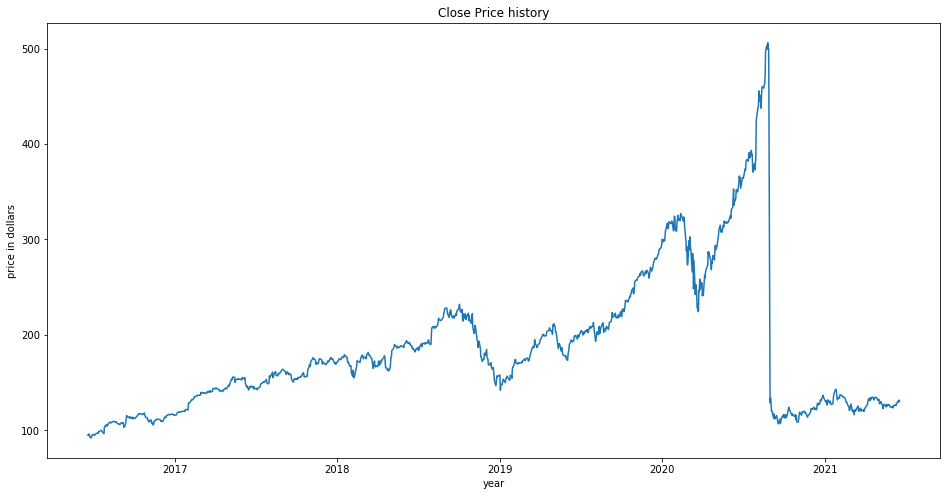

In [6]:
plt.figure(figsize=(16,8))
plt.plot(df["close"])
plt.title("Close Price history")
plt.xlabel("year")
plt.ylabel("price in dollars")
plt.show()

In [9]:
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(df)):
    new_dataset["Date"][i]=df['date'][i]
    new_dataset["Close"][i]=df["close"][i]
new_dataset.index = new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

In [11]:
# splitting dataset into train and test data
final_dataset=new_dataset.values
n = len(new_dataset)
train_data=final_dataset[0:int(n*.60),:]
test_data=final_dataset[int(n*.60):,:]

n,len(train_data),len(test_data)

(1259, 755, 504)

In [12]:
# Applying MinMax scaler
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

In [16]:
# train data
x_train_data,y_train_data=[],[]
time_step = 60
for i in range(time_step,len(train_data)):
    x_train_data.append(scaled_data[i-time_step:i,0])
    y_train_data.append(scaled_data[i,0])
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

print(x_train_data.shape, y_train_data.shape)

(695, 60, 1) (695,)


In [18]:
# test data
inputs_data=new_dataset[len(new_dataset)-len(test_data)-time_step:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

X_test,Y_test=[],[]
for i in range(time_step,inputs_data.shape[0]):
    X_test.append(inputs_data[i-time_step:i,0])
    Y_test.append(inputs_data[i,0],)
X_test,Y_test = np.array(X_test),np.array(Y_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
print(X_test.shape,Y_test.shape)

(504, 60, 1) (504,)


In [19]:
# Calculating test scores
def score(model):

    trainScore = model.evaluate(x_train_data,y_train_data,verbose=0)
    print("Train Score : %8f MSE (%8f RMSE)" % (trainScore, math.sqrt(trainScore)) )

    testScore = model.evaluate(X_test,Y_test,verbose=0)
    print("Test Score : %8f MSE (%8f RMSE)" % (testScore, math.sqrt(testScore)) )

In [20]:
# lstm model
lstm_model=Sequential()
lstm_model.add(LSTM(units=100,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=100))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error',optimizer='adam')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 100)           40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [22]:
lstm_model.fit(x_train_data,y_train_data,epochs=10,batch_size=128,verbose=1)

Epoch 1/10
6/6 [==============================] - 1s 173ms/step - loss: 0.0060
Epoch 2/10
6/6 [==============================] - 1s 205ms/step - loss: 0.0018
Epoch 3/10
6/6 [==============================] - 1s 195ms/step - loss: 9.6502e-04
Epoch 4/10
6/6 [==============================] - 1s 209ms/step - loss: 9.3509e-04
Epoch 5/10
6/6 [==============================] - 1s 202ms/step - loss: 6.2311e-04
Epoch 6/10
6/6 [==============================] - 1s 238ms/step - loss: 4.0007e-04
Epoch 7/10
6/6 [==============================] - 1s 221ms/step - loss: 3.0905e-04
Epoch 8/10
6/6 [==============================] - 1s 213ms/step - loss: 2.7062e-04
Epoch 9/10
6/6 [==============================] - 1s 196ms/step - loss: 2.4124e-04
Epoch 10/10
6/6 [==============================] - 1s 198ms/step - loss: 2.3540e-04


In [23]:
lstm_model.save("lstm_model.h5")

In [25]:
# improved lstm model
improved_model=Sequential()
improved_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
improved_model.add(Dropout(0.2))
improved_model.add(LSTM(units = 50))
improved_model.add(Dropout(0.2))
improved_model.add(Dense(units = 1))
improved_model.compile(loss='mean_squared_error',optimizer='adam')

improved_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [26]:
improved_model.fit(x_train_data,y_train_data,epochs=50,batch_size=8,verbose=1)

Epoch 1/50
87/87 [==============================] - 7s 39ms/step - loss: 0.0051
Epoch 2/50
87/87 [==============================] - 4s 41ms/step - loss: 7.3811e-04
Epoch 3/50
87/87 [==============================] - 3s 40ms/step - loss: 4.8917e-04
Epoch 4/50
87/87 [==============================] - 4s 41ms/step - loss: 3.6691e-04
Epoch 5/50
87/87 [==============================] - 4s 44ms/step - loss: 5.2146e-04
Epoch 6/50
87/87 [==============================] - 4s 42ms/step - loss: 3.4454e-04
Epoch 7/50
87/87 [==============================] - 4s 43ms/step - loss: 3.6279e-04
Epoch 8/50
87/87 [==============================] - 4s 43ms/step - loss: 3.3768e-04
Epoch 9/50
87/87 [==============================] - 4s 43ms/step - loss: 3.8764e-04
Epoch 10/50
87/87 [==============================] - 4s 44ms/step - loss: 2.6743e-04
Epoch 11/50
87/87 [==============================] - 4s 44ms/step - loss: 3.0716e-04
Epoch 12/50
87/87 [==============================] - 4s 50ms/step - loss: 2.96

In [27]:
improved_model.save("improved_model.h5")

In [28]:
# compraing scores of both models
print("LSTM Model")
score(lstm_model)
print("")
print("Improved Model")
score(improved_model)

LSTM Model
Train Score : 0.000232 MSE (0.015240 RMSE)
Test Score : 0.008625 MSE (0.092869 RMSE)

Improved Model
Train Score : 0.000066 MSE (0.008152 RMSE)
Test Score : 0.002464 MSE (0.049637 RMSE)


In [29]:
# lstm model prediction
# prediction for train data
train_predict = lstm_model.predict(x_train_data)
train_predict = scaler.inverse_transform(train_predict)

# prediction for test data
y_pred = lstm_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)


In [31]:
# improved lstm model prediction
# prediction for train data
train_predict2 = improved_model.predict(x_train_data)
train_predict2 = scaler.inverse_transform(train_predict2)

# prediction for test data
y_pred2 = improved_model.predict(X_test)
y_pred2 = scaler.inverse_transform(y_pred2)

In [32]:
train_data = new_dataset[60:int(n*0.60)]
test_data = new_dataset[int(n*0.60):]
print(len(test_data),len(y_pred))
train_data['predictions'] = train_predict
test_data['predictions'] = y_pred

train_data['improved'] = train_predict2
test_data['improved'] = y_pred2

504 504
C:\Users\91953\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\91953\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\91953\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas

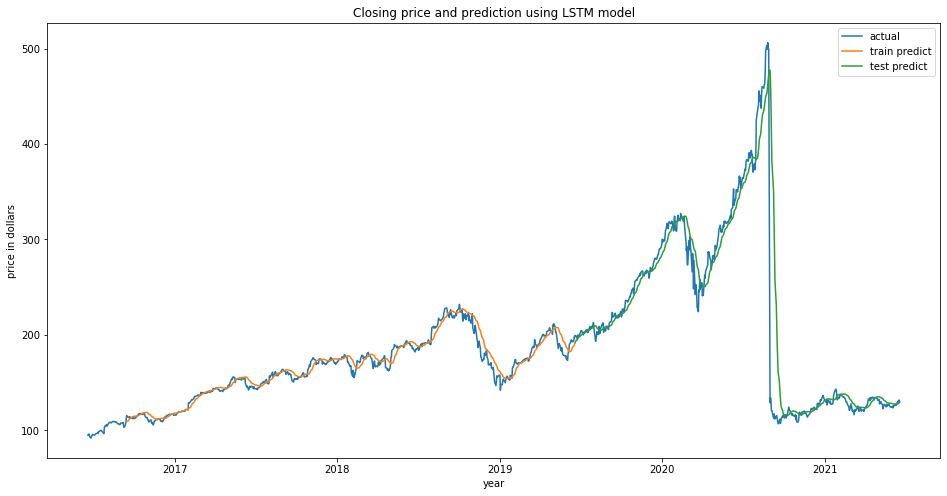

In [33]:
plt.figure(figsize=(16,8))
plt.plot(new_dataset,label='actual')
plt.plot(train_data['predictions'],label = "train predict")
plt.plot(test_data['predictions'],label = "test predict")

plt.title("Closing price and prediction using LSTM model")
plt.xlabel("year")
plt.ylabel("price in dollars")
plt.legend()
plt.show()

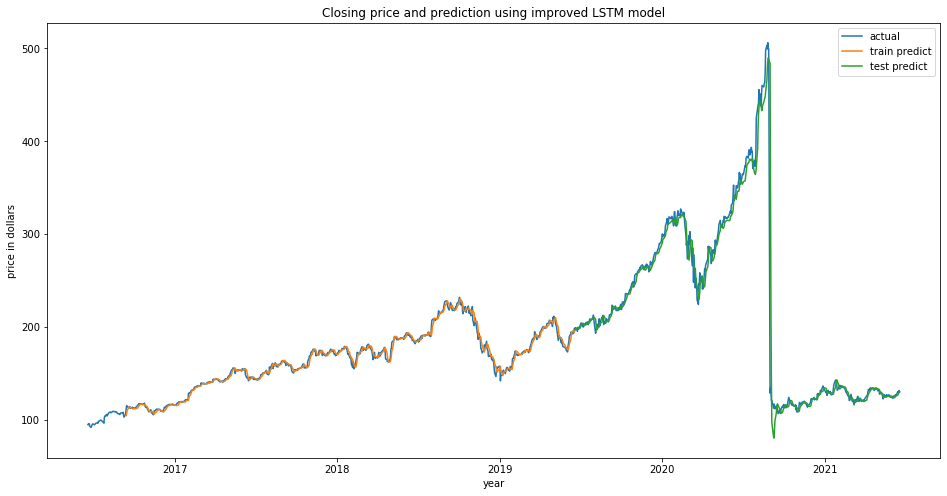

In [34]:
plt.figure(figsize=(16,8))
plt.plot(new_dataset,label='actual')
plt.plot(train_data['improved'],label = "train predict")
plt.plot(test_data['improved'],label = "test predict")

plt.title("Closing price and prediction using improved LSTM model")
plt.xlabel("year")
plt.ylabel("price in dollars")
plt.legend()
plt.show()

In [36]:
# forecast for next 30 days
days = 30
for i in range(days):

    new_input = new_dataset.values[-time_step:]
    new_input = scaler.fit_transform(new_input)
    new_input = np.array(new_input)
    new_input = new_input.reshape(1,-1)
    new_input = np.reshape(new_input,(1,time_step,1))

    new_pred = improved_model.predict(new_input)
    new_pred = scaler.inverse_transform(new_pred)

    date = new_dataset.index[-1]+pd.to_timedelta(1,unit='d')
    new_dataset = new_dataset.append(pd.DataFrame({"Close":new_pred[0][0]},index=[date]))
    

predicted_plot = new_dataset[-days:]

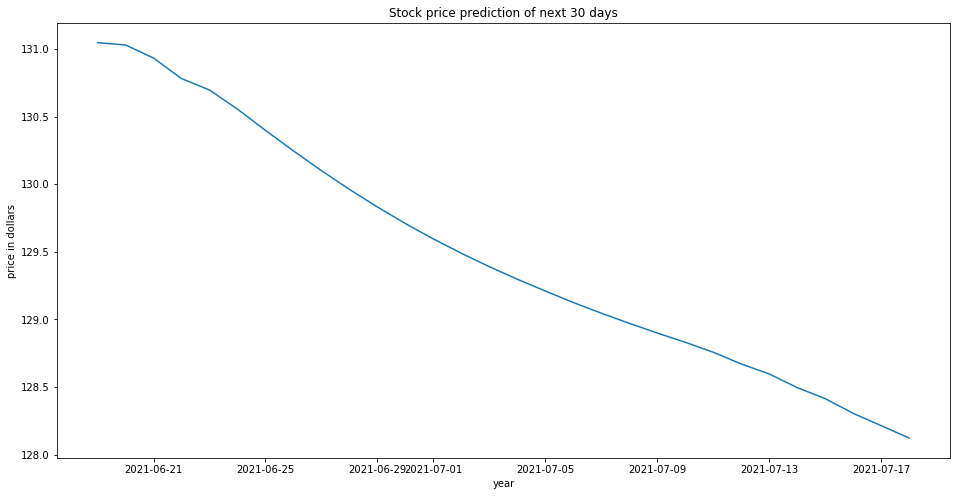

In [37]:

plt.figure(figsize=(16,8))
plt.plot(predicted_plot["Close"])
plt.title("Stock price prediction of next 30 days")
plt.xlabel("year")
plt.ylabel("price in dollars")
plt.show()

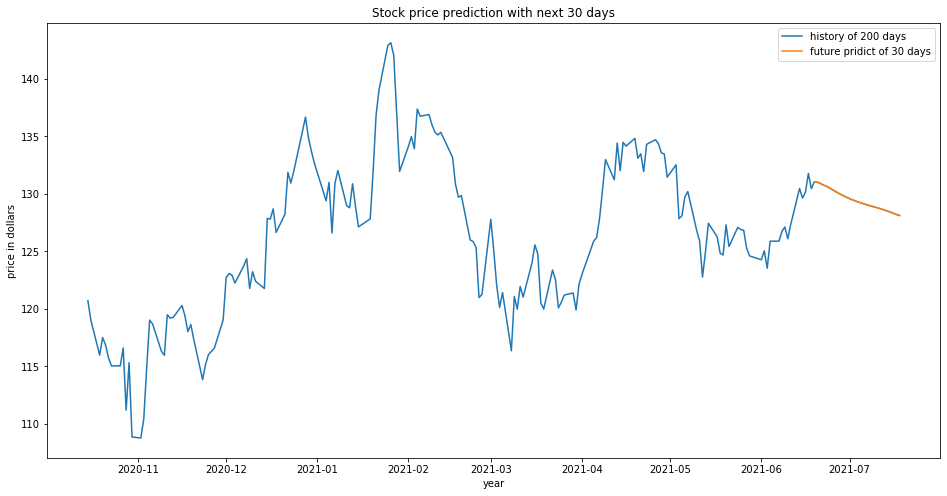

In [39]:
plt.figure(figsize=(16,8))
plt.title("Stock price prediction with next 30 days")
plt.plot(new_dataset[-200:]["Close"],label='history of 200 days')
plt.plot(predicted_plot["Close"],label='future pridict of 30 days')
plt.xlabel("year")
plt.ylabel("price in dollars")
plt.legend()
plt.show()

In [1]:
# delete last row
# new_dataset = new_dataset.head(-days)
# new_dataset.tail()